## Dependencies

In [1]:
# installing dependencies
# !pip install tensorflow==2.9.0 tensorflow-gpu==2.9.0 opencv-python mediapipe sklearn matplotlib

In [1]:
# importing all required libraries

import cv2
import os
import time
import numpy as np
import mediapipe as mp
from matplotlib import pyplot as plt

# split and transform data
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# check accuracy
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

# build and train LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

## Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
# Command for an error: The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support
# !pip uninstall opencv-python-headless -y 
# !pip install opencv-python --upgrade

In [9]:
cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # qprint(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

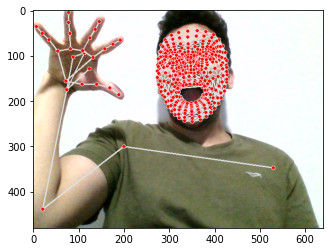

In [10]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## Extract Keypoint Values

In [9]:
len(results.right_hand_landmarks.landmark)

21

In [10]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [11]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [12]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)


In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
result_test = extract_keypoints(results)

In [15]:
print(len(result_test))
468*3+33*4+21*3+21*3

1662


1662

In [16]:
np.save('0', result_test)
np.load('0.npy')

array([ 0.56972325,  0.57346511, -1.29653227, ...,  0.17681505,
        0.38747633, -0.06478579])

## Setup Folders for Collection

In [18]:
# Folder structure
# A
## 0
## 1
## 2
## ...
## 29
# B

# C

labels = ['A','B','C','D',]#'E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(labels)

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [19]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## Collect Keypoint Values from webcam to train and test

In [20]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [22]:
cap.release()
cv2.destroyAllWindows()

## Preprocess Data and Create Labels and Features

In [98]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'A': 0, 'B': 1, 'C': 2}

In [99]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [100]:
np.array(sequences).shape

(90, 30, 1662)

Here we have 90 videos, 30 frames each and 1662 key points

In [101]:
np.array(labels).shape

(90,)

In [102]:
X = np.array(sequences)

In [103]:
X.shape

(90, 30, 1662)

In [104]:
y = to_categorical(labels).astype(int)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [107]:
y_test.shape

(5, 3)

## Build and Train LSTM Neural Network

In [108]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [128]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

* The requirements to use the cuDNN implementation are:<br>

activation == tanh    <br>
recurrent_activation == sigmoid    <br>
recurrent_dropout == 0    <br>
unroll is False    <br>
use_bias is True    <br>
Inputs, if use masking, are strictly right-padded.    <br>
Eager execution is enabled in the outermost context.    <br>

In [130]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [113]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 5s 767ms/step - loss: 2.3384 - categorical_accuracy: 0.3176
Epoch 2/2000
3/3 [==============================] - 1s 228ms/step - loss: 12.4285 - categorical_accuracy: 0.2588
Epoch 3/2000
3/3 [==============================] - 1s 260ms/step - loss: 11.9603 - categorical_accuracy: 0.3529
Epoch 4/2000
3/3 [==============================] - 1s 228ms/step - loss: 12.4649 - categorical_accuracy: 0.3176
Epoch 5/2000
3/3 [==============================] - 1s 247ms/step - loss: 26.4763 - categorical_accuracy: 0.3059
Epoch 6/2000
3/3 [==============================] - 1s 233ms/step - loss: 38.1422 - categorical_accuracy: 0.3294
Epoch 7/2000
3/3 [==============================] - 1s 223ms/step - loss: 86.5651 - categorical_accuracy: 0.3059
Epoch 8/2000
3/3 [==============================] - 1s 268ms/step - loss: 19.6490 - categorical_accuracy: 0.2941
Epoch 9/2000
3/3 [==============================] - 1s 220ms/step - loss: 29.6048 - categorical_a

3/3 [==============================] - 1s 219ms/step - loss: 0.7114 - categorical_accuracy: 0.6588
Epoch 146/2000
3/3 [==============================] - 1s 238ms/step - loss: 0.8224 - categorical_accuracy: 0.6353
Epoch 147/2000
3/3 [==============================] - 1s 561ms/step - loss: 0.8715 - categorical_accuracy: 0.5412
Epoch 148/2000
3/3 [==============================] - 1s 228ms/step - loss: 0.8907 - categorical_accuracy: 0.6000
Epoch 149/2000
3/3 [==============================] - 1s 263ms/step - loss: 0.7661 - categorical_accuracy: 0.6000
Epoch 150/2000
3/3 [==============================] - 1s 363ms/step - loss: 0.6711 - categorical_accuracy: 0.6941
Epoch 151/2000
3/3 [==============================] - 1s 245ms/step - loss: 0.6954 - categorical_accuracy: 0.6353
Epoch 152/2000
3/3 [==============================] - 1s 227ms/step - loss: 0.7898 - categorical_accuracy: 0.6235
Epoch 153/2000
3/3 [==============================] - 1s 645ms/step - loss: 0.7295 - categorical_accura

Epoch 217/2000
3/3 [==============================] - 1s 201ms/step - loss: 0.7628 - categorical_accuracy: 0.6941
Epoch 218/2000
3/3 [==============================] - 1s 187ms/step - loss: 0.6816 - categorical_accuracy: 0.6588
Epoch 219/2000
3/3 [==============================] - 1s 213ms/step - loss: 0.6856 - categorical_accuracy: 0.7059
Epoch 220/2000
3/3 [==============================] - 2s 725ms/step - loss: 0.8459 - categorical_accuracy: 0.6118
Epoch 221/2000
3/3 [==============================] - 1s 186ms/step - loss: 0.6833 - categorical_accuracy: 0.6471
Epoch 222/2000
3/3 [==============================] - 1s 211ms/step - loss: 0.8407 - categorical_accuracy: 0.6235
Epoch 223/2000
3/3 [==============================] - 1s 209ms/step - loss: 0.7007 - categorical_accuracy: 0.6824
Epoch 224/2000
3/3 [==============================] - 1s 378ms/step - loss: 0.6729 - categorical_accuracy: 0.6706
Epoch 225/2000
3/3 [==============================] - 1s 330ms/step - loss: 0.6845 - cat

3/3 [==============================] - 1s 208ms/step - loss: 0.4728 - categorical_accuracy: 0.8118
Epoch 361/2000
3/3 [==============================] - 1s 575ms/step - loss: 0.3785 - categorical_accuracy: 0.8588
Epoch 362/2000
3/3 [==============================] - 1s 215ms/step - loss: 0.4804 - categorical_accuracy: 0.8235
Epoch 363/2000
3/3 [==============================] - 1s 228ms/step - loss: 0.4205 - categorical_accuracy: 0.8235
Epoch 364/2000
3/3 [==============================] - 1s 218ms/step - loss: 0.5386 - categorical_accuracy: 0.8588
Epoch 365/2000
3/3 [==============================] - 1s 291ms/step - loss: 0.4993 - categorical_accuracy: 0.8118
Epoch 366/2000
3/3 [==============================] - 1s 206ms/step - loss: 0.4739 - categorical_accuracy: 0.8588
Epoch 367/2000
3/3 [==============================] - 1s 227ms/step - loss: 0.5075 - categorical_accuracy: 0.8353
Epoch 368/2000
3/3 [==============================] - 1s 198ms/step - loss: 0.5211 - categorical_accura

3/3 [==============================] - 1s 367ms/step - loss: 0.4298 - categorical_accuracy: 0.8353
Epoch 433/2000
3/3 [==============================] - 1s 342ms/step - loss: 0.4559 - categorical_accuracy: 0.8000
Epoch 434/2000
3/3 [==============================] - 1s 357ms/step - loss: 0.4929 - categorical_accuracy: 0.8235
Epoch 435/2000
3/3 [==============================] - 1s 369ms/step - loss: 0.4452 - categorical_accuracy: 0.8353
Epoch 436/2000
3/3 [==============================] - 1s 363ms/step - loss: 0.4022 - categorical_accuracy: 0.8471
Epoch 437/2000
3/3 [==============================] - 1s 349ms/step - loss: 0.3120 - categorical_accuracy: 0.8824
Epoch 438/2000
3/3 [==============================] - 2s 969ms/step - loss: 0.2550 - categorical_accuracy: 0.9059
Epoch 439/2000
3/3 [==============================] - 1s 579ms/step - loss: 0.3732 - categorical_accuracy: 0.8941
Epoch 440/2000
3/3 [==============================] - 1s 348ms/step - loss: 0.3132 - categorical_accura

Epoch 504/2000
3/3 [==============================] - 1s 271ms/step - loss: 0.2510 - categorical_accuracy: 0.9176
Epoch 505/2000
3/3 [==============================] - 1s 229ms/step - loss: 0.2282 - categorical_accuracy: 0.9294
Epoch 506/2000
3/3 [==============================] - 2s 852ms/step - loss: 0.2238 - categorical_accuracy: 0.9412
Epoch 507/2000
3/3 [==============================] - 1s 219ms/step - loss: 0.2073 - categorical_accuracy: 0.9176
Epoch 508/2000
3/3 [==============================] - 1s 233ms/step - loss: 0.2915 - categorical_accuracy: 0.9176
Epoch 509/2000
3/3 [==============================] - 1s 317ms/step - loss: 0.2927 - categorical_accuracy: 0.8941
Epoch 510/2000
3/3 [==============================] - 1s 237ms/step - loss: 0.2723 - categorical_accuracy: 0.9059
Epoch 511/2000
3/3 [==============================] - 1s 205ms/step - loss: 0.3272 - categorical_accuracy: 0.8824
Epoch 512/2000
3/3 [==============================] - 1s 191ms/step - loss: 0.2533 - cat

3/3 [==============================] - 1s 333ms/step - loss: 0.3504 - categorical_accuracy: 0.8706
Epoch 648/2000
3/3 [==============================] - 1s 349ms/step - loss: 0.4136 - categorical_accuracy: 0.8353
Epoch 649/2000
3/3 [==============================] - 1s 355ms/step - loss: 0.4486 - categorical_accuracy: 0.8353
Epoch 650/2000
3/3 [==============================] - 2s 839ms/step - loss: 0.4423 - categorical_accuracy: 0.8471
Epoch 651/2000
3/3 [==============================] - 1s 298ms/step - loss: 0.2552 - categorical_accuracy: 0.8824
Epoch 652/2000
3/3 [==============================] - 1s 378ms/step - loss: 0.3553 - categorical_accuracy: 0.8706
Epoch 653/2000
3/3 [==============================] - 1s 384ms/step - loss: 0.3307 - categorical_accuracy: 0.8471
Epoch 654/2000
3/3 [==============================] - 2s 773ms/step - loss: 0.2718 - categorical_accuracy: 0.8941
Epoch 655/2000
3/3 [==============================] - 1s 537ms/step - loss: 0.2227 - categorical_accura

3/3 [==============================] - 1s 341ms/step - loss: 0.1621 - categorical_accuracy: 0.9412
Epoch 720/2000
3/3 [==============================] - 1s 358ms/step - loss: 0.1850 - categorical_accuracy: 0.9412
Epoch 721/2000
3/3 [==============================] - 1s 304ms/step - loss: 0.2836 - categorical_accuracy: 0.8824
Epoch 722/2000
3/3 [==============================] - 1s 308ms/step - loss: 0.2981 - categorical_accuracy: 0.8941
Epoch 723/2000
3/3 [==============================] - 1s 306ms/step - loss: 0.2089 - categorical_accuracy: 0.9294
Epoch 724/2000
3/3 [==============================] - 1s 590ms/step - loss: 0.1303 - categorical_accuracy: 0.9647
Epoch 725/2000
3/3 [==============================] - 1s 245ms/step - loss: 0.1176 - categorical_accuracy: 0.9647
Epoch 726/2000
3/3 [==============================] - 2s 904ms/step - loss: 0.0871 - categorical_accuracy: 0.9882
Epoch 727/2000
3/3 [==============================] - 1s 207ms/step - loss: 0.0919 - categorical_accura

Epoch 791/2000
3/3 [==============================] - 1s 280ms/step - loss: 0.6235 - categorical_accuracy: 0.7765
Epoch 792/2000
3/3 [==============================] - 1s 221ms/step - loss: 0.5313 - categorical_accuracy: 0.8000
Epoch 793/2000
3/3 [==============================] - 1s 479ms/step - loss: 0.3277 - categorical_accuracy: 0.8471
Epoch 794/2000
3/3 [==============================] - 1s 258ms/step - loss: 0.4414 - categorical_accuracy: 0.8588
Epoch 795/2000
3/3 [==============================] - 1s 276ms/step - loss: 0.3417 - categorical_accuracy: 0.8706
Epoch 796/2000
3/3 [==============================] - 1s 331ms/step - loss: 0.2669 - categorical_accuracy: 0.9176
Epoch 797/2000
3/3 [==============================] - 1s 491ms/step - loss: 0.2538 - categorical_accuracy: 0.9176
Epoch 798/2000
3/3 [==============================] - 2s 954ms/step - loss: 0.2562 - categorical_accuracy: 0.8941
Epoch 799/2000
3/3 [==============================] - 2s 996ms/step - loss: 0.2090 - cat

Epoch 934/2000
3/3 [==============================] - 1s 231ms/step - loss: 1.0880 - categorical_accuracy: 0.5647
Epoch 935/2000
3/3 [==============================] - 1s 382ms/step - loss: 1.1845 - categorical_accuracy: 0.5765
Epoch 936/2000
3/3 [==============================] - 1s 339ms/step - loss: 0.8022 - categorical_accuracy: 0.6235
Epoch 937/2000
3/3 [==============================] - 1s 341ms/step - loss: 0.7675 - categorical_accuracy: 0.5882
Epoch 938/2000
3/3 [==============================] - 1s 418ms/step - loss: 0.7480 - categorical_accuracy: 0.6824
Epoch 939/2000
3/3 [==============================] - 1s 339ms/step - loss: 0.6289 - categorical_accuracy: 0.7176
Epoch 940/2000
3/3 [==============================] - 1s 363ms/step - loss: 0.5838 - categorical_accuracy: 0.7294
Epoch 941/2000
3/3 [==============================] - 1s 375ms/step - loss: 0.6380 - categorical_accuracy: 0.7294
Epoch 942/2000
3/3 [==============================] - 2s 793ms/step - loss: 0.5674 - cat

3/3 [==============================] - 1s 398ms/step - loss: 0.0666 - categorical_accuracy: 0.9882
Epoch 1077/2000
3/3 [==============================] - 1s 328ms/step - loss: 0.0618 - categorical_accuracy: 0.9882
Epoch 1078/2000
3/3 [==============================] - 2s 720ms/step - loss: 0.0769 - categorical_accuracy: 0.9765
Epoch 1079/2000
3/3 [==============================] - 1s 370ms/step - loss: 0.0646 - categorical_accuracy: 0.9882
Epoch 1080/2000
3/3 [==============================] - 1s 345ms/step - loss: 0.0753 - categorical_accuracy: 0.9882
Epoch 1081/2000
3/3 [==============================] - 1s 351ms/step - loss: 0.2250 - categorical_accuracy: 0.9294
Epoch 1082/2000
3/3 [==============================] - 1s 344ms/step - loss: 0.1339 - categorical_accuracy: 0.9647
Epoch 1083/2000
3/3 [==============================] - 2s 751ms/step - loss: 0.1229 - categorical_accuracy: 0.9647
Epoch 1084/2000
3/3 [==============================] - 1s 267ms/step - loss: 0.0976 - categorica

3/3 [==============================] - 1s 226ms/step - loss: 0.0500 - categorical_accuracy: 0.9882
Epoch 1219/2000
3/3 [==============================] - 1s 219ms/step - loss: 0.0498 - categorical_accuracy: 0.9882
Epoch 1220/2000
3/3 [==============================] - 1s 295ms/step - loss: 0.0493 - categorical_accuracy: 0.9882
Epoch 1221/2000
3/3 [==============================] - 1s 236ms/step - loss: 0.0517 - categorical_accuracy: 0.9882
Epoch 1222/2000
3/3 [==============================] - 1s 266ms/step - loss: 0.0468 - categorical_accuracy: 0.9882
Epoch 1223/2000
3/3 [==============================] - 1s 227ms/step - loss: 0.0560 - categorical_accuracy: 0.9882
Epoch 1224/2000
3/3 [==============================] - 1s 268ms/step - loss: 0.0529 - categorical_accuracy: 0.9882
Epoch 1225/2000
3/3 [==============================] - 1s 234ms/step - loss: 0.0478 - categorical_accuracy: 0.9882
Epoch 1226/2000
3/3 [==============================] - 1s 320ms/step - loss: 0.0541 - categorica

3/3 [==============================] - 1s 294ms/step - loss: 1.0366 - categorical_accuracy: 0.4353
Epoch 1361/2000
3/3 [==============================] - 1s 292ms/step - loss: 1.0564 - categorical_accuracy: 0.3529
Epoch 1362/2000
3/3 [==============================] - 1s 272ms/step - loss: 1.0505 - categorical_accuracy: 0.4706
Epoch 1363/2000
3/3 [==============================] - 2s 687ms/step - loss: 1.0374 - categorical_accuracy: 0.3882
Epoch 1364/2000
3/3 [==============================] - 1s 290ms/step - loss: 1.0099 - categorical_accuracy: 0.4588
Epoch 1365/2000
3/3 [==============================] - 1s 272ms/step - loss: 1.0077 - categorical_accuracy: 0.5412
Epoch 1366/2000
3/3 [==============================] - 1s 314ms/step - loss: 0.9934 - categorical_accuracy: 0.5647
Epoch 1367/2000
3/3 [==============================] - 1s 282ms/step - loss: 0.9797 - categorical_accuracy: 0.5412
Epoch 1368/2000
3/3 [==============================] - 1s 364ms/step - loss: 1.0035 - categorica

3/3 [==============================] - 1s 248ms/step - loss: 0.8905 - categorical_accuracy: 0.6353
Epoch 1503/2000
3/3 [==============================] - 1s 415ms/step - loss: 0.7914 - categorical_accuracy: 0.6824
Epoch 1504/2000
3/3 [==============================] - 2s 914ms/step - loss: 0.6297 - categorical_accuracy: 0.7294
Epoch 1505/2000
3/3 [==============================] - 1s 226ms/step - loss: 0.6692 - categorical_accuracy: 0.6941
Epoch 1506/2000
3/3 [==============================] - 1s 330ms/step - loss: 0.7110 - categorical_accuracy: 0.7765
Epoch 1507/2000
3/3 [==============================] - 2s 824ms/step - loss: 0.7179 - categorical_accuracy: 0.6353
Epoch 1508/2000
3/3 [==============================] - 1s 327ms/step - loss: 0.7505 - categorical_accuracy: 0.6588
Epoch 1509/2000
3/3 [==============================] - 2s 834ms/step - loss: 0.7021 - categorical_accuracy: 0.7059
Epoch 1510/2000
3/3 [==============================] - 2s 873ms/step - loss: 0.6240 - categorica

3/3 [==============================] - 2s 863ms/step - loss: 0.3120 - categorical_accuracy: 0.9059
Epoch 1645/2000
3/3 [==============================] - 1s 281ms/step - loss: 0.3185 - categorical_accuracy: 0.8824
Epoch 1646/2000
3/3 [==============================] - 1s 209ms/step - loss: 0.3074 - categorical_accuracy: 0.9059
Epoch 1647/2000
3/3 [==============================] - 1s 207ms/step - loss: 0.3453 - categorical_accuracy: 0.8824
Epoch 1648/2000
3/3 [==============================] - 1s 217ms/step - loss: 0.3202 - categorical_accuracy: 0.8706
Epoch 1649/2000
3/3 [==============================] - 1s 217ms/step - loss: 0.3097 - categorical_accuracy: 0.9059
Epoch 1650/2000
3/3 [==============================] - 1s 212ms/step - loss: 0.2656 - categorical_accuracy: 0.8941
Epoch 1651/2000
3/3 [==============================] - 1s 225ms/step - loss: 0.3021 - categorical_accuracy: 0.8941
Epoch 1652/2000
3/3 [==============================] - 1s 232ms/step - loss: 0.3946 - categorica

3/3 [==============================] - 1s 284ms/step - loss: 0.4253 - categorical_accuracy: 0.8118
Epoch 1787/2000
3/3 [==============================] - 1s 277ms/step - loss: 0.2981 - categorical_accuracy: 0.8588
Epoch 1788/2000
3/3 [==============================] - 1s 300ms/step - loss: 0.3055 - categorical_accuracy: 0.9059
Epoch 1789/2000
3/3 [==============================] - 1s 370ms/step - loss: 0.2982 - categorical_accuracy: 0.8706
Epoch 1790/2000
3/3 [==============================] - 2s 754ms/step - loss: 0.3131 - categorical_accuracy: 0.8471
Epoch 1791/2000
3/3 [==============================] - 1s 296ms/step - loss: 0.2803 - categorical_accuracy: 0.8941
Epoch 1792/2000
3/3 [==============================] - 1s 417ms/step - loss: 0.3207 - categorical_accuracy: 0.9059
Epoch 1793/2000
3/3 [==============================] - 1s 512ms/step - loss: 0.2775 - categorical_accuracy: 0.8824
Epoch 1794/2000
3/3 [==============================] - 1s 593ms/step - loss: 0.2893 - categorica

3/3 [==============================] - 1s 253ms/step - loss: 0.1754 - categorical_accuracy: 0.9412
Epoch 1929/2000
3/3 [==============================] - 1s 649ms/step - loss: 0.1492 - categorical_accuracy: 0.9529
Epoch 1930/2000
3/3 [==============================] - 1s 276ms/step - loss: 0.2048 - categorical_accuracy: 0.9294
Epoch 1931/2000
3/3 [==============================] - 1s 282ms/step - loss: 0.1797 - categorical_accuracy: 0.9529
Epoch 1932/2000
3/3 [==============================] - 1s 266ms/step - loss: 0.1648 - categorical_accuracy: 0.9294
Epoch 1933/2000
3/3 [==============================] - 1s 305ms/step - loss: 0.1873 - categorical_accuracy: 0.9176
Epoch 1934/2000
3/3 [==============================] - 1s 290ms/step - loss: 0.1431 - categorical_accuracy: 0.9412
Epoch 1935/2000
3/3 [==============================] - 1s 298ms/step - loss: 0.1701 - categorical_accuracy: 0.9294
Epoch 1936/2000
3/3 [==============================] - 1s 368ms/step - loss: 0.1489 - categorica

In [131]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

## Make Predictions

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[1])]

In [ ]:
actions[np.argmax(y_test[1])]

## Save Weights

In [ ]:
model.save('action.h5')

In [ ]:
# del model

In [ ]:
# model.load_weights('action.h5')

## Evaluation using Confusion Matrix and Accuracy

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

## Test in Real Time

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))